## Cosmos DB 

Reference: https://github.com/Azure/azure-documentdb-python/tree/master/samples

In [1]:
%matplotlib inline

import pydocumentdb.document_client as document_client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from pprint import pprint
import itertools

import config as cfg

In [2]:
ENDPOINT = cfg.settings['end_point']
MASTERKEY = cfg.settings['master_key']

In [3]:
client = document_client.DocumentClient(ENDPOINT, {'masterKey': MASTERKEY})

In [1]:
# list(client.ReadDatabases())
list(db['id'] for db in client.ReadDatabases())

In [5]:
db_id = cfg.settings['database_id']

In [2]:
for db in client.ReadDatabases():
    if db['id'] == db_id:
         db_link = db['_self']
db_link

In [3]:
# list(client.ReadCollections(db_link))
list(coll['id'] for coll in client.ReadCollections(db_link))

In [8]:
coll_id = cfg.settings['collection_id']

In [11]:
for coll in client.ReadCollections(db_link):
    if coll['id'] == coll_id:
         coll_link = coll['_self']
coll_link

# Query with SQL

In [44]:
query = """
SELECT c.timestamp, 
    c.modelscore,
    c.predictpassfail,
    c.groundtruth,
    c.tester,
    c.failType,
    c.imagename
FROM c
WHERE c.timestamp > '2018-03-12'
"""

In [45]:
docs = client.QueryDocuments(coll_link, query)

In [12]:
# for i in range (1,10):
#     pprint(next(iter(docs)))

In [78]:
# %%time
# df_query = pd.DataFrame()
# for doc in docs:
#     df_query = df_query.append(doc, ignore_index=True)

CPU times: user 8min 10s, sys: 116 ms, total: 8min 10s
Wall time: 10min 24s


In [4]:
# df_query.info()

In [46]:
%%time
timestamp = []
score = []
modelresult = []
groundtruth = []
tester = []
warning_reason = []
imagename = []

for doc in docs:
    timestamp.append(doc['timestamp'])
    score.append(doc['modelscore'])
    modelresult.append(doc['predictpassfail'])
    groundtruth.append(doc['groundtruth'])
    tester.append(doc['tester'])
    warning_reason.append(doc['failType'])
    imagename.append(doc['imagename'])

CPU times: user 2.95 s, sys: 0 ns, total: 2.95 s
Wall time: 5min 10s


In [13]:
df_query = pd.DataFrame({
    'timestamp':timestamp,
    'score':score,
    'modelresult':modelresult,
    'groundtruth':groundtruth,
    'tester':tester,
    'warning_reason':warning_reason,
    'imagename':imagename
})

In [14]:
df_query.shape

(24906, 12)

# Query all documents

In [14]:
docs = client.ReadDocuments(coll_link)
# print (list(docs))
# next(iter(docs))
# for i in range (1,10):
#     print(next(iter(docs)))

In [15]:
%%time
startime = []
endtime = []
score = []
modelresult = []
groundtruth = []
tester = []
warning_reason = []
imagename = []

for doc in docs:
    startime.append(doc['starttime'])
    endtime.append(doc['endtime'])
    score.append(doc['modelscore'])
    modelresult.append(doc['predictpassfail'])
    groundtruth.append(doc['groundtruth'])
    tester.append(doc['tester'])
    warning_reason.append(doc['failType'])
    imagename.append(doc['imagename'])

CPU times: user 3.93 s, sys: 0 ns, total: 3.93 s
Wall time: 4min 30s


In [16]:
df_cosmos = pd.DataFrame({
    'starttime':startime,
    'endtime':endtime,
    'score':score,
    'modelresult':modelresult,
    'groundtruth':groundtruth'
    'tester':tester,
    'warning_reason':warning_reason,
    'imagename':imagename
})

In [5]:
df_cosmos.info()

In [6]:
print(df_cosmos[1:100])

In [7]:
df_cosmos['starttime'] = pd.to_datetime(df_cosmos['starttime'],format='%Y-%m-%d-%H-%M-%S')
df_cosmos['endtime'] = pd.to_datetime(df_cosmos['endtime'],format='%Y-%m-%d-%H-%M-%S')
df_cosmos.sort_values(by='starttime')

# Evaluate Results

1 means pass

3 means fail

There are also 4 and 0 which were considered as pass but we will be removing these since their classification is uncertain.

In [20]:
# df = df_cosmos[df_cosmos['starttime']>'2018-03-03'] 
df = df_cosmos
df.shape

(62295, 11)

In [8]:
df[1:100]

In [22]:
df['groundtruth'].value_counts()

1    48074
0     9732
3     3325
4     1164
Name: opresult, dtype: int64

In [23]:
df['modelresult'].value_counts()

1    36129
3    26166
Name: modelresult, dtype: int64

In [42]:
# width = 0.35
# mp=plt.hist(df['modelresult'])

In [24]:
metrics_dict = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1': f1_score,
}

In [25]:
def classification_metrics(y_true, y_pred, metrics=metrics_dict):
    return {metric_name:metric(y_true, y_pred) for metric_name, metric in metrics.items()}

In [26]:
def all_metrics(y_test, y_pred):
#     y_pred = binarize_prediction(y_pred_proba)
    cm_dict = classification_metrics(y_test, y_pred)
#     cm_dict['AUC'] = roc_auc_score(y_test, y_pred_proba)
    cm_dict['Confusion Matrix'] = confusion_matrix(y_test, y_pred).tolist()
    return cm_dict

In [27]:
# filter out 0 and 4
df = df[df.opresult.isin([1,3])]
df.shape

(51399, 11)

In [9]:
# df = df.reset_index(drop=True)
df

In [29]:
df[df.columns.difference(['warning_reason'])].duplicated().sum()

0

In [181]:
# df = df[df.columns.difference(['warning_reason'])]
# df.drop_duplicates(inplace=True)

In [30]:
df.shape

(51399, 11)

In [31]:
df['groundtruth'].value_counts()

1    48074
3     3325
Name: opresult, dtype: int64

In [32]:
y_series = [0 if value == 1 else 1 for value in df['groundtruth']]
y = np.array(y_series)

In [117]:
# print(y[y==0].shape)
# print(y[y==1].shape)

In [33]:
df['modelresult'].value_counts()

1    32690
3    18709
Name: modelresult, dtype: int64

In [34]:
pred_series = [0 if value == 1 else 1 for value in df['modelresult']]
pred = np.array(pred_series)

In [37]:
# print(pred[pred==0].shape)
# print(pred[pred==1].shape)

In [37]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [35]:
cm_dict = all_metrics(y, pred)
cm_dict

{'Accuracy': 0.69353489367497423,
 'Confusion Matrix': [[32506, 15568], [184, 3141]],
 'F1': 0.28510483797767089,
 'Precision': 0.16788711315409696,
 'Recall': 0.94466165413533831}

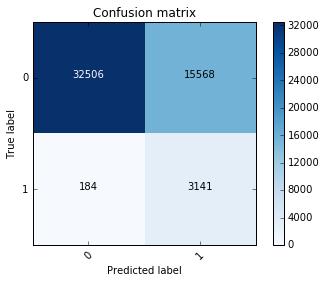

In [38]:
cm = np.asarray(cm_dict['Confusion Matrix'])
plot_confusion_matrix(cm, ['0','1'], normalize=False)

In [10]:
print( "The model eleminates {:.2f}% of pass components at a false negative rate of 5.0%.".format(cm[0][0] / (cm[0][0] + cm[0][1]) *100))

# Evaluate by Machine

In [41]:
def tester_results(df_all, tester):
    df_tester = df_all[df_all['tester'] == tester]
    print("\n" + tester)
    print(df_tester['groundtruth'].value_counts())
    y_series = [0 if value == 1 else 1 for value in df_tester['opresult']]
    y = np.array(y_series)
    pred_series = [0 if value == 1 else 1 for value in df_tester['modelresult']]
    pred = np.array(pred_series)
    cm_dict = all_metrics(y, pred)
    pprint(cm_dict)
    cm = np.asarray(cm_dict['Confusion Matrix'])
    plot_confusion_matrix(cm, ['0','1'], normalize=False)
    print( "The model eleminates {:.2f}% of pass components at a false negative rate of 5.0%.".format(cm[0][0] / (cm[0][0] + cm[0][1]) *100))
    return

In [13]:
for tst in df['tester'].unique():
    tester_results(df, tst)